# SimCLR example

Following this tutorial: https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial17/SimCLR.html


Contrastive learning creates embeddings that capture key features of the original data, making these representations more likely to contribute effectively to downstream prediction tasks. By learning to distinguish between similar and dissimilar examples, contrastive methods produce embeddings that preserve important semantic relationships present in the input data.

The SimCLR experiments demonstrate the following key insights:

- **Effectiveness with limited labeled data**: Using pre-trained embeddings, relatively high accuracy (**62.79%**) can be achieved even with a small amount of labeled data (**10 images per class, 100 total**).
- **Outperforming supervised learning**: This performance surpasses that of fully supervised learning on the same dataset. A ResNet trained from scratch achieved only **73.31% accuracy** using all available data (500 images per class).
- **Leveraging unlabeled data**: SimCLR's pre-training utilizes large amounts of unlabeled data to learn powerful feature representations. These pre-trained features can be effectively applied to classification tasks with limited labeled data.
Scalability with data size: Accuracy improves as more labeled data is used, reaching **81.33%** with 500 images per class, over **8% higher than the supervised model**.
- **Efficient transfer learning**: High accuracy can be achieved with minimal labeled data by pre-training embeddings through self-supervised learning. This approach is particularly valuable in domains where labeling is costly or large labeled datasets are difficult to obtain.

In summary, contrastive learning methods like SimCLR offer a powerful approach to leveraging unlabeled data. They result in robust and transferable representations that can significantly outperform traditional supervised learning, especially in scenarios with limited labeled data.


In [1]:
## Standard libraries
import os
from copy import deepcopy

import matplotlib
## Imports for plotting
import matplotlib.pyplot as plt
## PyTorch Lightning
import pytorch_lightning as pl
import seaborn as sns
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
## Torchvision
import torchvision
from matplotlib_inline.backend_inline import set_matplotlib_formats
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint
from torchvision import transforms
from torchvision.datasets import STL10
## tqdm for loading bars
from tqdm.notebook import tqdm

# 設定
plt.set_cmap("cividis")
%matplotlib inline
set_matplotlib_formats("svg", "pdf")  # For export
matplotlib.rcParams["lines.linewidth"] = 2.0
sns.set()

# Import tensorboard
%load_ext tensorboard

# Path to the folder where the datasets are/should be downloaded (e.g. CIFAR10)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial17"
# In this notebook, we use data loaders with heavier computational processing. It is recommended to use as many
# workers as possible in a data loader, which corresponds to the number of CPU cores
NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cpu
Number of workers: 14


<Figure size 640x480 with 0 Axes>

# DL data

In [8]:
import urllib.request
from urllib.error import HTTPError

# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# Files to download
pretrained_files = [
    "SimCLR.ckpt",
    "ResNet.ckpt",
    "tensorboards/SimCLR/events.out.tfevents.SimCLR",
    "tensorboards/classification/ResNet/events.out.tfevents.ResNet",
]
pretrained_files += [
    f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]
]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if "/" in file_name:
        os.makedirs(file_path.rsplit("/", 1)[0], exist_ok=True)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print(
                "Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n",
                e,
            )

# Data Augmentation

In [9]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [ ]:
contrast_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96),
        transforms.RandomApply(
            [
                transforms.ColorJitter(
                    brightness=0.5, contrast=0.5, saturation=0.5, hue=0.1
                )
            ],
            p=0.8,
        ),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

# Data load

In [11]:
unlabeled_data = STL10(
    root=DATASET_PATH,
    split="unlabeled",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)
train_data_contrast = STL10(
    root=DATASET_PATH,
    split="train",
    download=True,
    transform=ContrastiveTransformations(contrast_transforms, n_views=2),
)

100%|██████████████████████████████████████████████████████████████████████████████| 2.64G/2.64G [05:13<00:00, 8.42MB/s]


Seed set to 42


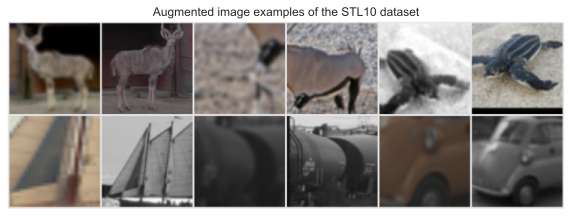

In [12]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack(
    [img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0
)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10, 5))
plt.title("Augmented image examples of the STL10 dataset")
plt.imshow(img_grid)
plt.axis("off")
plt.show()
plt.close()

# SimCLR

Loss function is InfoNCE:

$$
\begin{equation}
\begin{aligned}
\ell_{i, j} &= -\log \frac{\exp \left(\operatorname{sim}\left(z_i, z_j\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(z_i, z_k\right) / \tau\right)} \\
&= -\operatorname{sim}\left(z_i, z_j\right) / \tau + \log \left[ \sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(z_i, z_k\right) / \tau\right) \right].
\end{aligned}
\end{equation}
$$

Cosine similarity is used:

$$\begin{equation}
\operatorname{sim}\left(z_i, z_j\right)=\frac{z_i^{\top} \cdot z_j}{\left\|z_i\right\| \cdot\left\|z_j\right\|}
\end{equation}.
$$

In [13]:
class SimCLR(pl.LightningModule):

    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert (
            self.hparams.temperature > 0.0
        ), "The temperature must be a positive float!"
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(
            num_classes=4 * hidden_dim
        )  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4 * hidden_dim, hidden_dim),
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=self.hparams.max_epochs, eta_min=self.hparams.lr / 50
        )
        return [optimizer], [lr_scheduler]

    def info_nce_loss(self, batch, mode="train"):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)

        # Encode all images by ResNet.
        feats = self.convnet(imgs)

        # Calculate cosine similarity
        # Make it tensor and calculate the similarity
        cos_sim = F.cosine_similarity(feats[:, None, :], feats[None, :, :], dim=-1)

        # Mask out cosine similarity to itself
        # Replace self similarity to a tiny value
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)

        # Find positive example -> batch_size//2 away from the original example
        # Each positive example is shifted by batch_size positions in the similarity matrix
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0] // 2, dims=0)

        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()

        # Logging loss
        self.log(mode + "_loss", nll)

        # Prepare combined similarity matrix for ranking evaluation
        # Structure: [positive_score, all_negative_scores]
        comb_sim = torch.cat(
            [
                # Extract positive pairs and place in first column [2B, 1]
                cos_sim[pos_mask][:, None],  # Positive similarity scores
                # Mask out original positive pairs to create negative candidates [2B, 2B-1]
                cos_sim.masked_fill(
                    pos_mask, -9e15
                ),  # Filtered negatives (masked with -inf)
            ],
            dim=-1,
        )  # Final shape: [2B, 2B] (1 positive + 2B-1 negatives per row)

        # Calculate ranking position of positive examples
        # argsort(): Get indices of sorted similarities (descending order)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)

        # Calculate and log ranking-based evaluation metrics
        # Top-1 Accuracy: Positive is most similar (rank 0)
        self.log(mode + "_acc_top1", (sim_argsort == 0).float().mean())
        # Top-5 Accuracy: Positive in top 5 most similar (ranks 0-4)
        self.log(mode + "_acc_top5", (sim_argsort < 5).float().mean())
        # Mean Rank Position: Average position (1-based indexing)
        self.log(mode + "_acc_mean_pos", 1 + sim_argsort.float().mean())

        return nll

    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode="val")

# Trainer

In [15]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "SimCLR"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc_top5"),
            LearningRateMonitor("epoch"),
        ],
    )
    trainer.logger._default_hp_metric = (
        None  # Optional logging argument that we don't need
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "SimCLR.ckpt")
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = SimCLR.load_from_checkpoint(
            pretrained_filename
        )  # Automatically loads the model with the saved hyperparameters
    else:
        train_loader = data.DataLoader(
            unlabeled_data,
            batch_size=batch_size,
            shuffle=True,
            drop_last=True,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        val_loader = data.DataLoader(
            train_data_contrast,
            batch_size=batch_size,
            shuffle=False,
            drop_last=False,
            pin_memory=True,
            num_workers=NUM_WORKERS,
        )
        pl.seed_everything(42)  # To be reproducable
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )  # Load best checkpoint after training

    return model

In [16]:
simclr_model = train_simclr(
    batch_size=256,
    hidden_dim=128,
    lr=5e-4,
    temperature=0.07,
    weight_decay=1e-4,
    max_epochs=500,
)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/SimCLR.ckpt`


Found pretrained model at ../saved_models/tutorial17/SimCLR.ckpt, loading...


In [17]:
%tensorboard --logdir ../saved_models/tutorial17/tensorboards/SimCLR/

# Define Logistic Regression

In [18]:
class LogisticRegression(pl.LightningModule):

    def __init__(self, feature_dim, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        # Mapping from representation h to classes
        self.model = nn.Linear(feature_dim, num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.hparams.max_epochs * 0.6),
                int(self.hparams.max_epochs * 0.8),
            ],
            gamma=0.1,
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        feats, labels = batch
        preds = self.model(feats)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [20]:
img_transforms = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

train_img_data = STL10(
    root=DATASET_PATH, split="train", download=True, transform=img_transforms
)
test_img_data = STL10(
    root=DATASET_PATH, split="test", download=True, transform=img_transforms
)

print("Number of training examples:", len(train_img_data))
print("Number of test examples:", len(test_img_data))

Number of training examples: 5000
Number of test examples: 8000


# Obtained the embbeding from SimCLR by removing head $g$ function

In [21]:
@torch.no_grad()
def prepare_data_features(model, dataset):
    # Prepare model
    network = deepcopy(model.convnet)
    network.fc = nn.Identity()  # Removing projection head g(.)
    network.eval()
    network.to(device)

    # Encode all images
    data_loader = data.DataLoader(
        dataset, batch_size=64, num_workers=NUM_WORKERS, shuffle=False, drop_last=False
    )
    feats, labels = [], []
    for batch_imgs, batch_labels in tqdm(data_loader):
        batch_imgs = batch_imgs.to(device)
        batch_feats = network(batch_imgs)
        feats.append(batch_feats.detach().cpu())
        labels.append(batch_labels)

    feats = torch.cat(feats, dim=0)
    labels = torch.cat(labels, dim=0)

    # Sort images by labels
    labels, idxs = labels.sort()
    feats = feats[idxs]

    return data.TensorDataset(feats, labels)

In [22]:
train_feats_simclr = prepare_data_features(simclr_model, train_img_data)
test_feats_simclr = prepare_data_features(simclr_model, test_img_data)

  0%|          | 0/79 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

In [24]:
train_feats_simclr.tensors

(tensor([[4.9665e-01, 0.0000e+00, 2.0173e+00,  ..., 1.2418e-02, 5.6073e-01,
          3.4225e-01],
         [2.2884e-01, 0.0000e+00, 2.8918e-01,  ..., 6.4951e-01, 3.3277e-01,
          5.9593e-01],
         [2.9981e-01, 1.8118e-03, 7.6399e-01,  ..., 6.6152e-01, 7.2054e-01,
          0.0000e+00],
         ...,
         [6.6105e-01, 4.9767e-01, 5.2893e-02,  ..., 7.5884e-01, 8.0199e-01,
          2.1700e-01],
         [1.4511e+00, 1.8896e-01, 8.9397e-02,  ..., 9.8536e-02, 1.2796e+00,
          2.9809e-02],
         [0.0000e+00, 5.4853e-01, 3.9515e-02,  ..., 8.9701e-01, 3.5572e-01,
          5.8562e-01]]),
 tensor([0, 0, 0,  ..., 9, 9, 9]))

In [25]:
test_feats_simclr.tensors

(tensor([[7.6215e-01, 0.0000e+00, 6.6851e-02,  ..., 1.0584e+00, 6.5343e-01,
          1.1955e-02],
         [8.8422e-01, 0.0000e+00, 6.8296e-02,  ..., 1.4865e+00, 7.0546e-01,
          1.7311e-01],
         [7.6282e-01, 7.5442e-04, 1.1657e+00,  ..., 8.9210e-01, 5.1285e-01,
          1.6623e-01],
         ...,
         [2.2359e-01, 6.4887e-01, 2.9761e-01,  ..., 2.5334e-01, 9.5917e-01,
          5.2849e-01],
         [3.2128e-01, 4.3573e-01, 5.2970e-02,  ..., 1.5765e+00, 1.7692e+00,
          5.1815e-01],
         [6.6601e-02, 3.4108e-01, 4.1899e-02,  ..., 3.7317e-01, 9.8295e-01,
          0.0000e+00]]),
 tensor([0, 0, 0,  ..., 9, 9, 9]))

# Training logistic regression

In [27]:
def train_logreg(
    batch_size,
    train_feats_data,
    test_feats_data,
    model_suffix,
    max_epochs=100,
    **kwargs,
):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "LogisticRegression"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        enable_progress_bar=False,
        check_val_every_n_epoch=10,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_feats_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False,
        pin_memory=True,
        num_workers=0,
    )
    test_loader = data.DataLoader(
        test_feats_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=0,
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(
        CHECKPOINT_PATH, f"LogisticRegression_{model_suffix}.ckpt"
    )
    if os.path.isfile(pretrained_filename):
        print(f"Found pretrained model at {pretrained_filename}, loading...")
        model = LogisticRegression.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = LogisticRegression(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = LogisticRegression.load_from_checkpoint(
            trainer.checkpoint_callback.best_model_path
        )

    # Test best model on train and validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": test_result[0]["test_acc"]}

    return model, result

In [28]:
def get_smaller_dataset(original_dataset, num_imgs_per_label):
    new_dataset = data.TensorDataset(
        *[
            t.unflatten(0, (10, -1))[:, :num_imgs_per_label].flatten(0, 1)
            for t in original_dataset.tensors
        ]
    )
    return new_dataset

In [29]:
results = {}
for num_imgs_per_label in [10, 20, 50, 100, 200, 500]:
    sub_train_set = get_smaller_dataset(train_feats_simclr, num_imgs_per_label)
    _, small_set_results = train_logreg(
        batch_size=64,
        train_feats_data=sub_train_set,
        test_feats_data=test_feats_simclr,
        model_suffix=num_imgs_per_label,
        feature_dim=train_feats_simclr.tensors[0].shape[1],
        num_classes=10,
        lr=1e-3,
        weight_decay=1e-3,
    )
    results[num_imgs_per_label] = small_set_results

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_10.ckpt`
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The

Found pretrained model at ../saved_models/tutorial17/LogisticRegression_10.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_20.ckpt, loading...


Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_20.ckpt`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_50.ckpt`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_100.ckpt`


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_50.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_100.ckpt, loading...


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_200.ckpt`
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/LogisticRegression_500.ckpt`


Found pretrained model at ../saved_models/tutorial17/LogisticRegression_200.ckpt, loading...
Found pretrained model at ../saved_models/tutorial17/LogisticRegression_500.ckpt, loading...


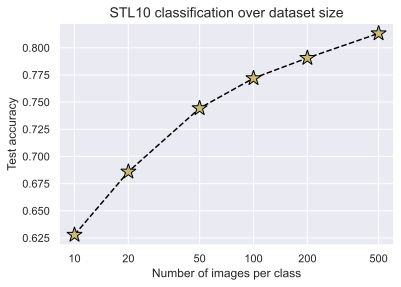

Test accuracy for  10 images per label: 62.79%
Test accuracy for  20 images per label: 68.60%
Test accuracy for  50 images per label: 74.44%
Test accuracy for 100 images per label: 77.20%
Test accuracy for 200 images per label: 79.06%
Test accuracy for 500 images per label: 81.33%


In [30]:
dataset_sizes = sorted([k for k in results])
test_scores = [results[k]["test"] for k in dataset_sizes]

fig = plt.figure(figsize=(6, 4))
plt.plot(
    dataset_sizes,
    test_scores,
    "--",
    color="#000",
    marker="*",
    markeredgecolor="#000",
    markerfacecolor="y",
    markersize=16,
)
plt.xscale("log")
plt.xticks(dataset_sizes, labels=dataset_sizes)
plt.title("STL10 classification over dataset size", fontsize=14)
plt.xlabel("Number of images per class")
plt.ylabel("Test accuracy")
plt.minorticks_off()
plt.show()

for k, score in zip(dataset_sizes, test_scores):
    print(f"Test accuracy for {k:3d} images per label: {100*score:4.2f}%")

# Baseline

In [31]:
class ResNet(pl.LightningModule):

    def __init__(self, num_classes, lr, weight_decay, max_epochs=100):
        super().__init__()
        self.save_hyperparameters()
        self.model = torchvision.models.resnet18(num_classes=num_classes)

    def configure_optimizers(self):
        optimizer = optim.AdamW(
            self.parameters(),
            lr=self.hparams.lr,
            weight_decay=self.hparams.weight_decay,
        )
        lr_scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[
                int(self.hparams.max_epochs * 0.7),
                int(self.hparams.max_epochs * 0.9),
            ],
            gamma=0.1,
        )
        return [optimizer], [lr_scheduler]

    def _calculate_loss(self, batch, mode="train"):
        imgs, labels = batch
        preds = self.model(imgs)
        loss = F.cross_entropy(preds, labels)
        acc = (preds.argmax(dim=-1) == labels).float().mean()

        self.log(mode + "_loss", loss)
        self.log(mode + "_acc", acc)
        return loss

    def training_step(self, batch, batch_idx):
        return self._calculate_loss(batch, mode="train")

    def validation_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="val")

    def test_step(self, batch, batch_idx):
        self._calculate_loss(batch, mode="test")

In [32]:
train_transforms = transforms.Compose(
    [
        transforms.RandomHorizontalFlip(),
        transforms.RandomResizedCrop(size=96, scale=(0.8, 1.0)),
        transforms.RandomGrayscale(p=0.2),
        transforms.GaussianBlur(kernel_size=9, sigma=(0.1, 0.5)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]
)

train_img_aug_data = STL10(
    root=DATASET_PATH, split="train", download=True, transform=train_transforms
)

In [33]:
def train_resnet(batch_size, max_epochs=100, **kwargs):
    trainer = pl.Trainer(
        default_root_dir=os.path.join(CHECKPOINT_PATH, "ResNet"),
        accelerator="gpu" if str(device).startswith("cuda") else "cpu",
        devices=1,
        max_epochs=max_epochs,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc"),
            LearningRateMonitor("epoch"),
        ],
        check_val_every_n_epoch=2,
    )
    trainer.logger._default_hp_metric = None

    # Data loaders
    train_loader = data.DataLoader(
        train_img_aug_data,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    test_loader = data.DataLoader(
        test_img_data,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )

    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "ResNet.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model at %s, loading..." % pretrained_filename)
        model = ResNet.load_from_checkpoint(pretrained_filename)
    else:
        pl.seed_everything(42)  # To be reproducable
        model = ResNet(**kwargs)
        trainer.fit(model, train_loader, test_loader)
        model = ResNet.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    # Test best model on validation set
    train_result = trainer.test(model, train_loader, verbose=False)
    val_result = trainer.test(model, test_loader, verbose=False)
    result = {"train": train_result[0]["test_acc"], "test": val_result[0]["test_acc"]}

    return model, result

In [34]:
resnet_model, resnet_result = train_resnet(
    batch_size=64, num_classes=10, lr=1e-3, weight_decay=2e-4, max_epochs=100
)
print(f"Accuracy on training set: {100*resnet_result['train']:4.2f}%")
print(f"Accuracy on test set: {100*resnet_result['test']:4.2f}%")

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
Lightning automatically upgraded your loaded checkpoint from v1.3.4 to v2.5.0.post0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../saved_models/tutorial17/ResNet.ckpt`


Found pretrained model at ../saved_models/tutorial17/ResNet.ckpt, loading...


/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:476: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/Users/inouey2/code/Constrastive_learning_sample/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                        | 0/? [00:00…

Testing: |                                                                                        | 0/? [00:00…

Accuracy on training set: 99.80%
Accuracy on test set: 73.31%
